In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [0]:
# root_path = '/content/gdrive/My Drive/Colab Notebooks/godl/'
# %cd /content/gdrive/My\ Drive/Colab\ Notebooks/godl/
# !cp train\ \(9\).zip /content/.
# !cp test_ApKoW4T.csv /content/.
# %cd /content
# !unzip train\ \(9\).zip;

In [0]:
import os

In [0]:
DATA_DIR = '/content/'
IMAGE_DIR = os.path.join(DATA_DIR, "images/")
SNAPSHOT_DIR = "/content/gdrive/My Drive/godl_submission/model_snapshot/"
OUTPUT_DIR = "/content/gdrive/My Drive/godl_submission/preds/"

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
import sys
import os
import numpy as np
import pandas as pd
import shutil
import os
import math

In [0]:
from sklearn.metrics import f1_score, accuracy_score

In [0]:
df = pd.read_csv('train.csv', dtype='str')
df_test = pd.read_csv('test_ApKoW4T.csv', dtype='str')

In [0]:
# tsms = get_transforms(max_rotate=30, max_zoom=1.3, max_warp=0.3, p_affine=1)
# tsms = get_transforms(max_rotate=30, max_zoom=1.3, max_warp=0.4, p_affine=1, p_lighting=1)
tsms = ([
    crop_pad(row_pct=(0.5,1), col_pct=(0.5,1), padding_mode='reflection', p=.75),
    flip_lr(p=.75),
    symmetric_warp(magnitude=(-0.2, 0.2), p=.75),
    perspective_warp(magnitude=(-0.2, 0.2), p=.75),
    rotate(degrees = (-20, 20), p=.75),
    zoom(scale=(1,1.3), p=.75),
    brightness(change=(.4, .6), p=.75),
    contrast(scale=(.8,1.25), p=.75),
    cutout(p=.5),
    squish(scale=(.8,1.25), p=.75),
    jitter(magnitude=(-0.01, 0.01), p=.5),
#     rgb_randomize(p=.75)
#     dihedral(p=.75),
],[])


In [0]:
def get_data_set(size=224, batch_size=32, tsms=tsms):
    np.random.seed(100)
    if tsms is None:
        tsms = ([],[])
    data = ImageDataBunch.from_df(path=IMAGE_DIR, df=df, valid_pct=0.2, ds_tfms=tsms, size=size, 
                                  resize_method=ResizeMethod.SQUISH, padding_mode='reflection',
                                  bs=batch_size, no_check=True).normalize(imagenet_stats)
    test = ImageList.from_df(df_test, path=IMAGE_DIR)
    data.add_test(test)
    return data

In [0]:
data = get_data_set(size=(128,128), batch_size=32, tsms=tsms)

In [0]:
data.classes, data.c, data.batch_size

(['1', '2', '3', '4', '5'], 5, 32)

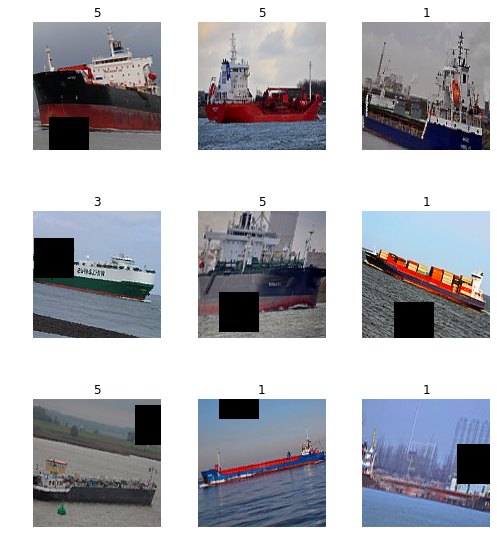

In [0]:
data.show_batch(rows=3, figsize=(7, 8))

In [0]:
head_reg4 = nn.Sequential(
    AdaptiveConcatPool2d(),
    Flatten(),
    nn.Linear(3840, 2048),
    nn.ReLU(),
    nn.BatchNorm1d(2048),
    nn.Dropout(0.5),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, 5),
)
learn = cnn_learner(data, models.densenet201, metrics=[accuracy], custom_head=head_reg4)

In [0]:
# learn.summary()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


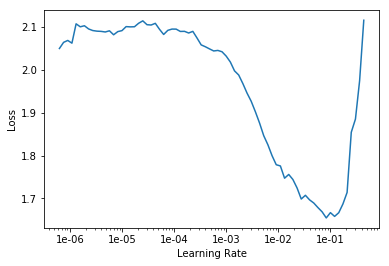

In [0]:
learn.recorder.plot()

In [0]:
lrs = 1e-03

In [0]:
learn.fit_one_cycle(10, max_lr=lrs)

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


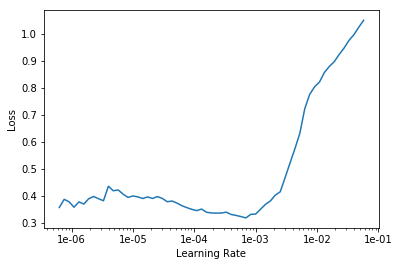

In [0]:
learn.recorder.plot()

In [0]:
lrs = slice(1e-05, 1e-03)

slice(1e-05, 0.001, None)

#### Play around with different image sizes(I tried 128, 160, 192, 224, 256 and 320) And different transformations and multiple iterations and saved multiple snapshots of the model.

In [0]:
torch.cuda.empty_cache()

In [0]:
learn.data = get_data_set(size=(224,224), batch_size=32)

In [0]:
cb = [callbacks.tracker.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best-model')]

In [0]:
learn.fit_one_cycle(50, max_lr=lrs, callbacks=cb)

In [0]:
learn.recorder.plot_losses()

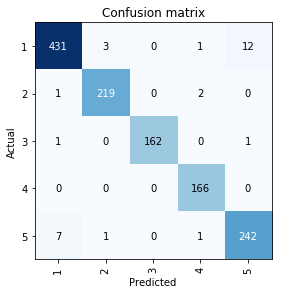

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
print(accuracy_score(interp.y_true, interp.pred_class), f1_score(interp.y_true, interp.pred_class, average='weighted'))

0.976 0.9760110792956975


#### Test Time Augmentation with different zoom scale and without any random transformation. Select the best scale on the basis of validation score.

In [0]:
learn.data = get_data_set(size=(224,224), batch_size=32, tsms = None)
scale_scores = []
for scale in [.9, .95, 1, 1.05, 1.10, 1.15, 1.20, 1.25]:
  loglosses, y = learn.TTA(scale=scale)
  scale_scores.append((scale, accuracy_score(y, loglosses.argmax(1)), f1_score(y, loglosses.argmax(1), average='weighted')))
  print(scale_scores[-1])

(1.25, 0.9744, 0.974414091286252)


In [0]:
scale_scores

[(0.95, 0.9776, 0.9776016367502692),
 (1, 0.9768, 0.976805467903653),
 (1.05, 0.9784, 0.978420172454149),
 (1.1, 0.9792, 0.9792142017896526),
 (1.15, 0.9784, 0.978420172454149),
 (1.2, 0.976, 0.9760134252161988),
 (1.25, 0.9744, 0.974414091286252)]

In [0]:
# Best score with scale=1.1, will be used for test TTA. Save the model

In [0]:
learn.save(SNAPSHOT_DIR + 'dense201-224-9760')